In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Specify the path to your Excel file
excel_file_path = '/kaggle/input/boe-data/DataScientist_009749_Dataset.xlsx'

# Load the Excel file and get the sheet names
xls = pd.ExcelFile(excel_file_path)
sheet_names = xls.sheet_names

# Display the sheet names
print("Sheet names in the Excel file:")
for sheet_name in sheet_names:
    print(sheet_name)
    
# Load the Excel file into a dictionary of DataFrames, where keys are sheet names
boe_data = pd.read_excel(excel_file_path, sheet_name=None)

# Access each DataFrame using the sheet name as the key
general_df = boe_data['Dataset 1 - General']
underwriting_df = boe_data['Dataset 2 - Underwriting']

Sheet names in the Excel file:
Dataset 1 - General
Dataset 2 - Underwriting


### `concatenate_first_row_with_space`

Concatenate the first row to the existing column headers with a space.

#### Parameters
- `df` (pd.DataFrame): Input DataFrame.

#### Returns
- `pd.DataFrame`: DataFrame with modified column headers.

---

### `rename_unnamed_to_firm_name`

Rename 'Unnamed: 0' to 'firm_name'.

#### Parameters
- `df` (pd.DataFrame): Input DataFrame.

#### Returns
- `pd.DataFrame`: DataFrame with modified column names.

---

**Usage Example:**
```python
# Concatenate the first row to the existing column headers and rename 'Unnamed: 0' to 'firm_name'
general_df = rename_unnamed_to_firm_name(concatenate_first_row_with_space(boe_data['Dataset 1 - General']))
underwriting_df = rename_unnamed_to_firm_name(concatenate_first_row_with_space(boe_data['Dataset 2 - Underwriting']))


In [3]:
def concatenate_first_row_with_space(df):
    """
    Concatenate the first row to the existing column headers with a space.

    Parameters:
    df (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with modified column headers.
    """
    first_row = df.iloc[0]
    df.columns = df.columns + ' ' + first_row.fillna('').astype(str)
    return df.iloc[1:]

def rename_unnamed_to_firm_name(df):
    """
    Rename 'Unnamed: 0' to 'firm_name'.

    Parameters:
    df (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with modified column names.
    """
    return df.rename(columns=lambda x: 'firm_name' if 'Unnamed: 0' in x else x)

# Concatenate the first row to the existing column headers and rename 'Unnamed: 0' to 'firm_name'
general_df = rename_unnamed_to_firm_name(concatenate_first_row_with_space(boe_data['Dataset 1 - General']))
underwriting_df = rename_unnamed_to_firm_name(concatenate_first_row_with_space(boe_data['Dataset 2 - Underwriting']))

In [4]:
# Access the first row of each DataFrame and convert it to a dictionary
general_dict = general_df.iloc[0].to_dict()
underwriting_dict = underwriting_df.iloc[0].to_dict()

# Print the resulting dictionaries
print("Dictionary for Dataset 1 - General:")
print(general_dict)

print("\nDictionary for Dataset 2 - Underwriting:")
print(underwriting_dict)


Dictionary for Dataset 1 - General:
{'firm_name': 'Firm 1', 'NWP (£m)  2016YE': -17754.10048645742, 'NWP (£m) .1 2017YE': 0, 'NWP (£m) .2 2018YE': 0, 'NWP (£m) .3 2019YE': 0, 'NWP (£m) .4 2020YE': 0, 'SCR (£m) 2016YE': 2021.3218622469626, 'SCR (£m).1 2017YE': 6.9400432308232975e-09, 'SCR (£m).2 2018YE': 0, 'SCR (£m).3 2019YE': 0, 'SCR (£m).4 2020YE': 0, 'EoF for SCR (£m) 2016YE': 2416.559784992302, 'EoF for SCR (£m).1 2017YE': 3.796177092257411, 'EoF for SCR (£m).2 2018YE': 0, 'EoF for SCR (£m).3 2019YE': 0, 'EoF for SCR (£m).4 2020YE': 0, 'SCR coverage ratio 2016YE': 0.16251965516029768, 'SCR coverage ratio.1 2017YE': 55887003.05757315, 'SCR coverage ratio.2 2018YE': 0, 'SCR coverage ratio.3 2019YE': 0, 'SCR coverage ratio.4 2020YE': 0, 'GWP (£m) 2016YE': 46.76803042498611, 'GWP (£m).1 2017YE': 0, 'GWP (£m).2 2018YE': 0, 'GWP (£m).3 2019YE': 0, 'GWP (£m).4 2020YE': 0, 'Total assets (£m) 2016YE': 63676.869102333185, 'Total assets (£m).1 2017YE': 9.566095697378056, 'Total assets (£m).2 

In [5]:
# Count the number of distinct firm names in each DataFrame
count_distinct_firm_names_general = general_df['firm_name'].nunique()
count_distinct_firm_names_underwriting = underwriting_df['firm_name'].nunique()

# Display the counts
print("Count of distinct firm names in Dataset 1 - General:", count_distinct_firm_names_general)
print("Count of distinct firm names in Dataset 2 - Underwriting:", count_distinct_firm_names_underwriting)

Count of distinct firm names in Dataset 1 - General: 325
Count of distinct firm names in Dataset 2 - Underwriting: 456


In [6]:
# Extract the distinct firm names from each DataFrame
distinct_firm_names_general = set(general_df['firm_name'])
distinct_firm_names_underwriting = set(underwriting_df['firm_name'])

# Find the common firm names
common_firm_names = distinct_firm_names_general.intersection(distinct_firm_names_underwriting)

# Display the number of common firm names
num_common_firm_names = len(common_firm_names)
print("Number of firm names common to both datasets:", num_common_firm_names)

Number of firm names common to both datasets: 325


### `rank_and_display_top_firms`

This function ranks and displays the top firms based on their size, calculated using total assets. It takes two DataFrames, `general_df` and `underwriting_df`, merges them on the 'firm_name' column, and then calculates the firm size by considering the total assets for the year 2016. The firms are then ranked in descending order based on their size, and the top firms are displayed. The number of top firms to display is customizable, with a default value of 10.

#### Parameters
- `general_df` (pd.DataFrame): General DataFrame.
- `underwriting_df` (pd.DataFrame): Underwriting DataFrame.
- `num_top_firms` (int): Number of top firms to display (default is 10).

#### Returns
- `pd.DataFrame`: DataFrame containing the firm names and their corresponding sizes, ranked from the largest to the smallest.

---

**Usage Example:**
```python
# Example usage:
rank_and_display_top_firms(general_df, underwriting_df)


In [7]:
merged_df = pd.merge(general_df, underwriting_df, on='firm_name', how='inner')

def rank_and_display_top_firms(general_df, underwriting_df, num_top_firms=10):
    """
    Rank and display the top firms based on firm size.

    Parameters:
    - general_df (pd.DataFrame): General DataFrame.
    - underwriting_df (pd.DataFrame): Underwriting DataFrame.
    - num_top_firms (int): Number of top firms to display (default is 10).

    Returns:
    - pd.DataFrame: Top firms by size.
    """
    # Merge general and underwriting DataFrames
    merged_df = pd.merge(general_df, underwriting_df, on='firm_name', how='inner')

    # Calculate firm size (e.g., using Total Assets)
    merged_df['Firm Size'] = merged_df['Total assets (£m) 2016YE']

    # Rank firms based on size
    ranked_firms = merged_df.sort_values(by='Firm Size', ascending=False).reset_index(drop=True)

    # Display the top firms
    top_firms = ranked_firms[['firm_name', 'Firm Size']].head(num_top_firms)

    return top_firms

# Example usage:
rank_and_display_top_firms(general_df, underwriting_df)


,firm_name,Firm Size
0,Firm 10,260340.85252
1,Firm 101,172242.646093
2,Firm 105,167831.817602
3,Firm 311,147474.200904
4,Firm 247,141289.948363
5,Firm 34,135949.88457
6,Firm 216,133568.696689
7,Firm 151,98684.556732
8,Firm 120,96554.361055
9,Firm 7,93321.457594


### `plot_nwp_trends_top_firms`

This function generates a stacked bar plot to visualize the Net Written Premium (NWP) trends over time for the top firms. It takes a merged DataFrame (`merged_df`) containing relevant columns, a list of NWP columns (`nwp_columns`), and an optional parameter for the number of top firms to include in the plot (default is 10). The NWP columns are converted to numeric values, and firms are ranked based on their size, calculated using total assets. The top firms are then selected, and a stacked bar plot is created, showing the NWP trends for each firm over the specified years. The plot is displayed with a custom color gradient, and the legend is positioned for easy interpretation.

#### Parameters
- `merged_df` (pd.DataFrame): Merged DataFrame with relevant columns.
- `nwp_columns` (list): List of NWP columns.
- `num_top_firms` (int): Number of top firms to include in the plot (default is 10).

#### Returns
- None (displays the plot).

---

**Usage Example:**
```python
# Example usage:
nwp_columns = ['NWP (£m)  2016YE', 'NWP (£m) .1 2017YE', 'NWP (£m) .2 2018YE', 'NWP (£m) .3 2019YE', 'NWP (£m) .4 2020YE']
plot_nwp_trends_top_firms(merged_df, nwp_columns)


<Figure size 1200x600 with 0 Axes>

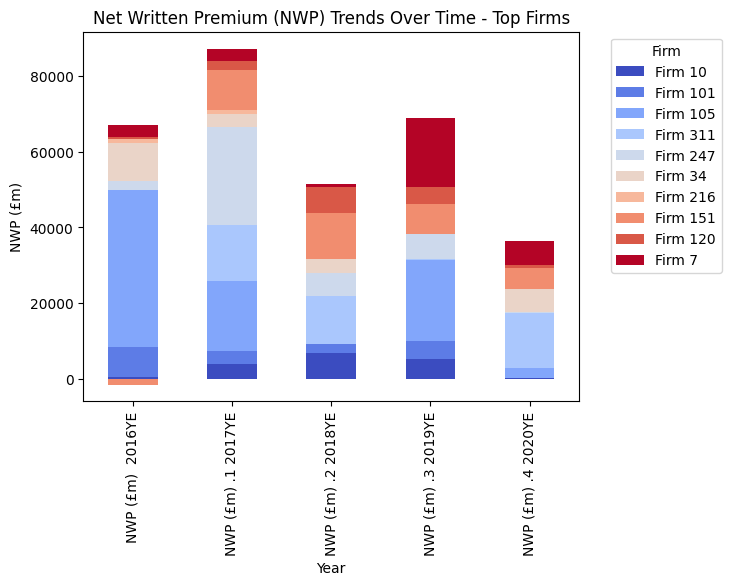

In [8]:
def plot_nwp_trends_top_firms(merged_df, nwp_columns, num_top_firms=10):
    """
    Plot Net Written Premium (NWP) trends over time for the top firms.

    Parameters:
    - merged_df (pd.DataFrame): Merged DataFrame with relevant columns.
    - nwp_columns (list): List of NWP columns.
    - num_top_firms (int): Number of top firms to include in the plot (default is 10).

    Returns:
    - None (displays the plot).
    """
    # Convert NWP columns to numeric
    merged_df[nwp_columns] = merged_df[nwp_columns].apply(pd.to_numeric, errors='coerce')

    # Calculate firm size (e.g., using Total Assets)
    merged_df['Firm Size'] = merged_df['Total assets (£m) 2016YE']

    # Rank firms based on size
    ranked_firms = merged_df.sort_values(by='Firm Size', ascending=False)

    # Select top firms
    top_firms = ranked_firms.head(num_top_firms)

    # Select relevant columns for NWP for top firms
    nwp_columns_top_firms = ['firm_name'] + nwp_columns
    nwp_data_top_firms = top_firms[nwp_columns_top_firms].set_index('firm_name').T

    # Plot stacked bar plot for top firms with custom color gradient and legend position
    plt.figure(figsize=(12, 6))
    nwp_data_top_firms.plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title('Net Written Premium (NWP) Trends Over Time - Top Firms')
    plt.xlabel('Year')
    plt.ylabel('NWP (£m)')
    plt.legend(title='Firm', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

nwp_columns = ['NWP (£m)  2016YE', 'NWP (£m) .1 2017YE', 'NWP (£m) .2 2018YE', 'NWP (£m) .3 2019YE', 'NWP (£m) .4 2020YE']
plot_nwp_trends_top_firms(merged_df, nwp_columns)


### `identify_scr_outliers`

This function helps identify outliers in the Solvency Capital Requirement (SCR) coverage ratio for each year. The function takes a merged DataFrame (`merged_df`) containing relevant columns, a list of SCR coverage ratio columns (`scr_columns`), and an optional threshold parameter (default is 100). 

The SCR coverage ratio represents the proportion of a firm's available capital to its required capital for absorbing potential losses. The function transforms the input DataFrame for better visualization and identifies firms where the SCR coverage ratio exceeds the specified threshold. The identified outliers are then returned in a DataFrame (`outliers_df`).

#### Parameters
- `merged_df` (pd.DataFrame): Merged DataFrame with relevant columns.
- `scr_columns` (list): List of SCR coverage ratio columns.
- `threshold` (float): Threshold for identifying outliers (default is 100).

#### Returns
- `outliers_df` (pd.DataFrame): DataFrame containing firms with SCR coverage ratio > threshold.

---

**Usage Example:**
```python
# Example usage:
scr_columns = ['firm_name', 'SCR coverage ratio 2016YE', 'SCR coverage ratio.1 2017YE', 'SCR coverage ratio.2 2018YE', 'SCR coverage ratio.3 2019YE', 'SCR coverage ratio.4 2020YE']
outliers_df = identify_scr_outliers(merged_df, scr_columns)
print("Firms with SCR Coverage Ratio > 100%:")
print(outliers_df)


In [9]:
def identify_scr_outliers(merged_df, scr_columns, threshold=100):
    """
    Identify outliers in SCR coverage ratio for each year.

    Parameters:
    - merged_df (pd.DataFrame): Merged DataFrame with relevant columns.
    - scr_columns (list): List of SCR coverage ratio columns.
    - threshold (float): Threshold for identifying outliers (default is 100).

    Returns:
    - outliers_df (pd.DataFrame): DataFrame containing firms with SCR coverage ratio > threshold.
    """
    # Select relevant columns for SCR coverage ratio
    scr_data = merged_df[scr_columns]

    # Melt the DataFrame for better visualization
    melted_scr = pd.melt(scr_data, id_vars='firm_name', var_name='Year', value_name='SCR Coverage Ratio')

    # Identify outliers (e.g., firms with SCR coverage ratio > threshold)
    outliers_df = melted_scr[melted_scr['SCR Coverage Ratio'] > threshold]

    return outliers_df

scr_columns = ['firm_name', 'SCR coverage ratio 2016YE', 'SCR coverage ratio.1 2017YE', 'SCR coverage ratio.2 2018YE', 'SCR coverage ratio.3 2019YE', 'SCR coverage ratio.4 2020YE']
outliers_df = identify_scr_outliers(merged_df, scr_columns)
print("Firms with SCR Coverage Ratio > 100%:")
print(outliers_df)


Firms with SCR Coverage Ratio > 100%:
     firm_name                         Year SCR Coverage Ratio
290   Firm 291    SCR coverage ratio 2016YE         170.155693
319   Firm 320    SCR coverage ratio 2016YE     6735557.777192
325     Firm 1  SCR coverage ratio.1 2017YE    55887003.057573
451   Firm 127  SCR coverage ratio.1 2017YE      225855.082003
455   Firm 131  SCR coverage ratio.1 2017YE   926983361.362373
540   Firm 216  SCR coverage ratio.1 2017YE   999302877.175381
715    Firm 66  SCR coverage ratio.2 2018YE     7161991.975377
776   Firm 127  SCR coverage ratio.2 2018YE      168645.751937
940   Firm 291  SCR coverage ratio.2 2018YE         102.454171
1101  Firm 127  SCR coverage ratio.3 2019YE        84538.37128
1265  Firm 291  SCR coverage ratio.3 2019YE         125.186816
1426  Firm 127  SCR coverage ratio.4 2020YE       89529.277963


### `detect_significant_scr_deviation`

This function identifies firms with Solvency Capital Requirement (SCR) coverage ratios that deviate significantly from the average. The function takes a merged DataFrame (`merged_df`) with relevant columns, a list of SCR coverage ratio columns (`scr_columns`), and an optional deviation threshold parameter (default is 2).

The SCR coverage ratio represents the proportion of a firm's available capital to its required capital for absorbing potential losses. The function transforms the input DataFrame for better handling, calculates the average SCR coverage ratio for each firm, and then identifies firms with coverage ratios deviating significantly from the average by comparing them to a specified threshold.

The output is a DataFrame (`outliers_with_avg`) containing the identified firms along with their average SCR coverage ratios.

#### Parameters
- `merged_df` (pd.DataFrame): Merged DataFrame with relevant columns.
- `scr_columns` (list): List of SCR coverage ratio columns.
- `deviation_threshold` (float): Threshold for identifying significant deviation from the average (default is 2).

#### Returns
- `outliers_with_avg` (pd.DataFrame): DataFrame containing firms with significant deviation along with their average SCR coverage ratio.

---

**Usage Example:**
```python
# Example usage:
scr_columns = ['firm_name', 'SCR coverage ratio 2016YE', 'SCR coverage ratio.1 2017YE', 'SCR coverage ratio.2 2018YE', 'SCR coverage ratio.3 2019YE', 'SCR coverage ratio.4 2020YE']
outliers_with_avg = detect_significant_scr_deviation(merged_df, scr_columns)
print("Firms with SCR coverage ratio deviating significantly from the average:")
print(outliers_with_avg)


In [10]:
def detect_significant_scr_deviation(merged_df, scr_columns, deviation_threshold=2):
    """
    Identify firms with SCR coverage ratio deviating significantly from the average.

    Parameters:
    - merged_df (pd.DataFrame): Merged DataFrame with relevant columns.
    - scr_columns (list): List of SCR coverage ratio columns.
    - deviation_threshold (float): Threshold for identifying significant deviation from the average (default is 2).

    Returns:
    - outliers_with_avg (pd.DataFrame): DataFrame containing firms with significant deviation along with their average SCR coverage ratio.
    """
    # Select relevant columns for SCR coverage ratio
    scr_data = merged_df[scr_columns]

    # Melt the DataFrame for better handling
    melted_scr = pd.melt(scr_data, id_vars='firm_name', var_name='Year', value_name='SCR coverage ratio')

    # Extract only numeric values attached to "YE" in the 'Year' column
    melted_scr['Year'] = melted_scr['Year'].apply(lambda x: re.search(r'(\d+)YE', x).group(1) if re.search(r'(\d+)YE', x) else None)

    # Convert 'Year' column to numeric
    melted_scr['Year'] = pd.to_numeric(melted_scr['Year'], errors='coerce')

    # Calculate the average SCR coverage ratio for each firm
    average_coverage_ratio = melted_scr.groupby('firm_name')['SCR coverage ratio'].mean()

    # Identify firms with SCR coverage ratio deviating significantly from the average
    outliers = melted_scr[
        melted_scr.groupby('Year')['SCR coverage ratio'].transform(lambda x: (x - x.mean()).abs() > deviation_threshold * x.std())
    ]

    # Merge with the average coverage ratio
    outliers_with_avg = pd.merge(outliers, average_coverage_ratio, left_on='firm_name', right_index=True, suffixes=('_single_period', '_average'))

    return outliers_with_avg

# Example usage:
scr_columns = ['firm_name', 'SCR coverage ratio 2016YE', 'SCR coverage ratio.1 2017YE', 'SCR coverage ratio.2 2018YE', 'SCR coverage ratio.3 2019YE', 'SCR coverage ratio.4 2020YE']
outliers_with_avg = detect_significant_scr_deviation(merged_df, scr_columns)
print("Firms with SCR coverage ratio deviating significantly from the average:")
outliers_with_avg


Firms with SCR coverage ratio deviating significantly from the average:


,firm_name,Year,SCR coverage ratio_single_period,SCR coverage ratio_average
319,Firm 320,2016,6735557.777192,1347112.766534
455,Firm 131,2017,926983361.362373,185396672.77964
540,Firm 216,2017,999302877.175381,199860575.860586
715,Firm 66,2018,7161991.975377,1432400.012052
1101,Firm 127,2019,84538.37128,113713.696637
1426,Firm 127,2020,89529.277963,113713.696637


### `shorten_column_names`

This function shortens the column names of a DataFrame based on a provided dictionary of abbreviations. The goal is to create more concise and readable column names for easier analysis and visualization.

#### Parameters
- `df` (pd.DataFrame): DataFrame with columns to be shortened.
- `abbreviations` (dict): Dictionary containing mappings of full column names to abbreviated names. If not provided, default abbreviations are used.

#### Returns
- `pd.DataFrame`: DataFrame with shortened column names.

---

**Usage Example:**
```python
# Example usage:
merged_df = shorten_column_names(merged_df)


In [11]:
def shorten_column_names(df, abbreviations=None):
    """
    Shorten column names of a DataFrame based on a dictionary of abbreviations.

    Parameters:
    - df (pd.DataFrame): DataFrame with columns to be shortened.
    - abbreviations (dict): Dictionary containing mappings of full column names to abbreviated names.

    Returns:
    - pd.DataFrame: DataFrame with shortened column names.
    """
    if abbreviations is None:
        # Default abbreviations if not provided
        abbreviations = {
            'NWP (£m)': 'NWP',
            'SCR (£m)': 'SCR',
            'EoF for SCR (£m)': 'EoF_SCR',
            'SCR coverage ratio': 'SCR_coverage_ratio',
            'GWP (£m)': 'GWP',
            'Total assets (£m)': 'Total_assets',
            'Total liabilities (£m)': 'Total_liabilities',
            'Excess of assets over liabilities (£m) [= equity]': 'Excess_of_assets_over_liabilities',
            'Gross claims incurred (£m)': 'Gross_claims_incurred',
            'Gross BEL (inc. TPs as whole, pre-TMTP) (£m)': 'Gross_BEL',
            'Net BEL (inc. TPs as a whole, pre-TMTP) (£m)': 'Net_BEL',
            'Pure net claims ratio': 'Pure_net_claims_ratio',
            'Net expense ratio': 'Net_expense_ratio',
            'Net combined ratio': 'Net_combined_ratio',
            'Pure gross claims ratio': 'Pure_gross_claims_ratio',
            'Gross expense ratio': 'Gross_expense_ratio',
            'Gross combined ratio': 'Gross_combined_ratio',
            'Firm Size': 'Firm_Size'
        }

    # Function to create shortened column names
    def create_shortened_names(columns):
        shortened_columns = []
        for col in columns:
            for key, value in abbreviations.items():
                col = col.replace(key, value)
            # Replace '.1', '.2', '.3', '.4', 'YE' with a space
            col = col.replace('.1', '').replace('.2', '').replace('.3', '').replace('.4', '').replace('YE', '')
            shortened_columns.append(col.strip())
        return shortened_columns

    # Apply the function to create shortened column names
    shortened_columns = create_shortened_names(df.columns)

    # Create a dictionary to map old column names to new shortened column names
    column_mapping = dict(zip(df.columns, shortened_columns))

    # Rename the columns in the DataFrame
    df = df.rename(columns=column_mapping)

    return df

merged_df = shorten_column_names(merged_df)


In [12]:
merged_df.head()

,firm_name,NWP 2016,NWP 2017,NWP 2018,NWP 2019,NWP 2020,SCR 2016,SCR 2017,SCR 2018,SCR 2019,...,Gross_expense_ratio 2017,Gross_expense_ratio 2018,Gross_expense_ratio 2019,Gross_expense_ratio 2020,Gross_combined_ratio 2016,Gross_combined_ratio 2017,Gross_combined_ratio 2018,Gross_combined_ratio 2019,Gross_combined_ratio 2020,Firm_Size
0,Firm 1,-17754.100486,0.000000,0.000000,0.000000,0.000000,2021.321862,0.0,0,0,...,77.251254,0,0,0,0,0.675051,0,0,0,63676.869102
1,Firm 2,9.244369,0.098771,40.812426,35.643071,13.626145,16.459756,15.009073,14.227214,15.037066,...,0.685941,1.433284,0,0,1.750946,1.321523,1.545325,0,0,78.776524
2,Firm 3,0.000000,0.806130,36.620199,86.630018,54.744180,486.887796,495.786299,626.612217,81.242579,...,0,0,0,0,0,0,0,0,0,54.678352
3,Firm 4,19677.453353,41072.816156,20885.506445,14719.672914,49204.465136,15975.652771,15367.887099,10797.123319,22788.359468,...,0.285471,0.05415,0.051848,-0.162883,1.047234,0.476384,3.307379,1.247403,-2.303093,64985.734421
4,Firm 5,128.812208,10.407371,79.579663,79.423623,61.727295,32.742279,43.954039,31.622572,30.119285,...,0.232725,0.204508,0.131739,0.048703,0.243611,1.977732,2.495287,0.365455,1.133645,572.066906


### `plot_metric_eda`

This function generates visualizations (histograms and boxplots) for a specified metric over multiple years. It helps in exploring the distribution and statistical characteristics of the given metric across different time periods.

#### Parameters
- `metric_name` (str): The name of the metric to be plotted.

#### Returns
- None: Plots are displayed.

---

**Usage Example:**
```python
# Example usage:
metrics_to_plot = ['GWP', 'NWP', 'Gross_claims_incurred', 'Total_assets', 'Total_liabilities']

for metric in metrics_to_plot:
    plot_metric_eda(metric)


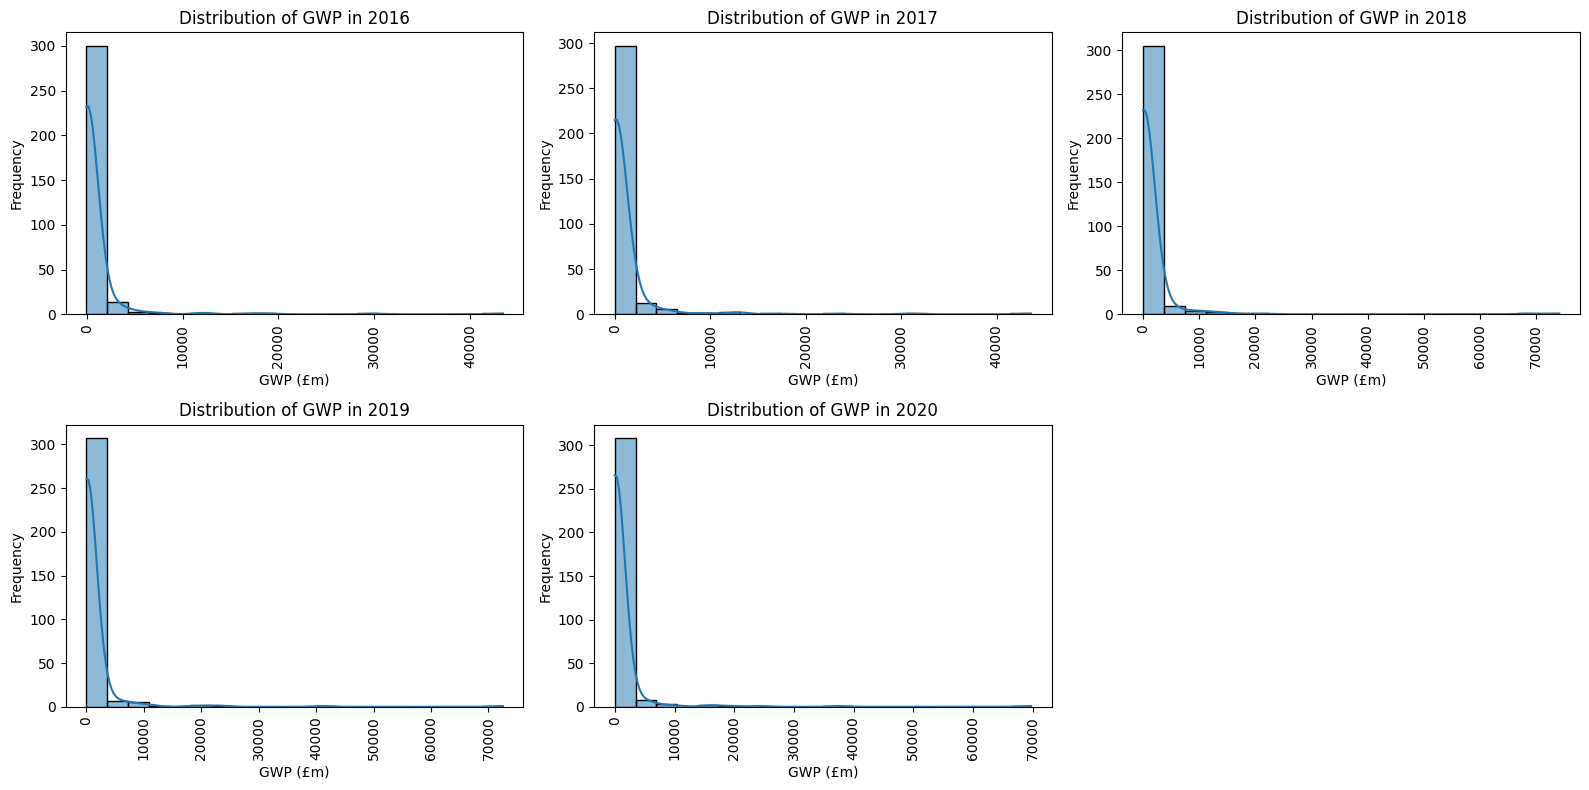

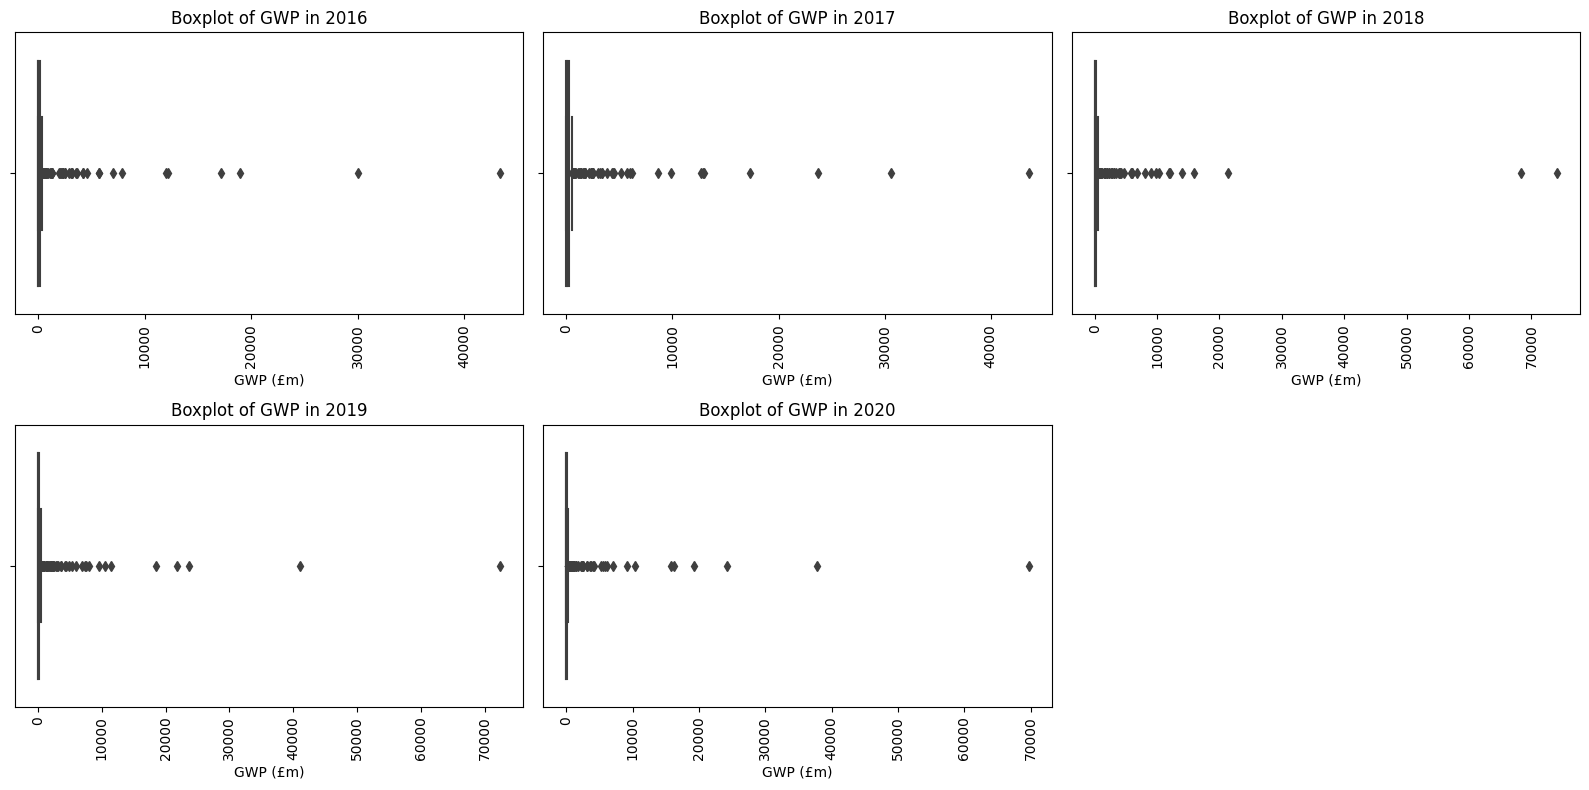

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

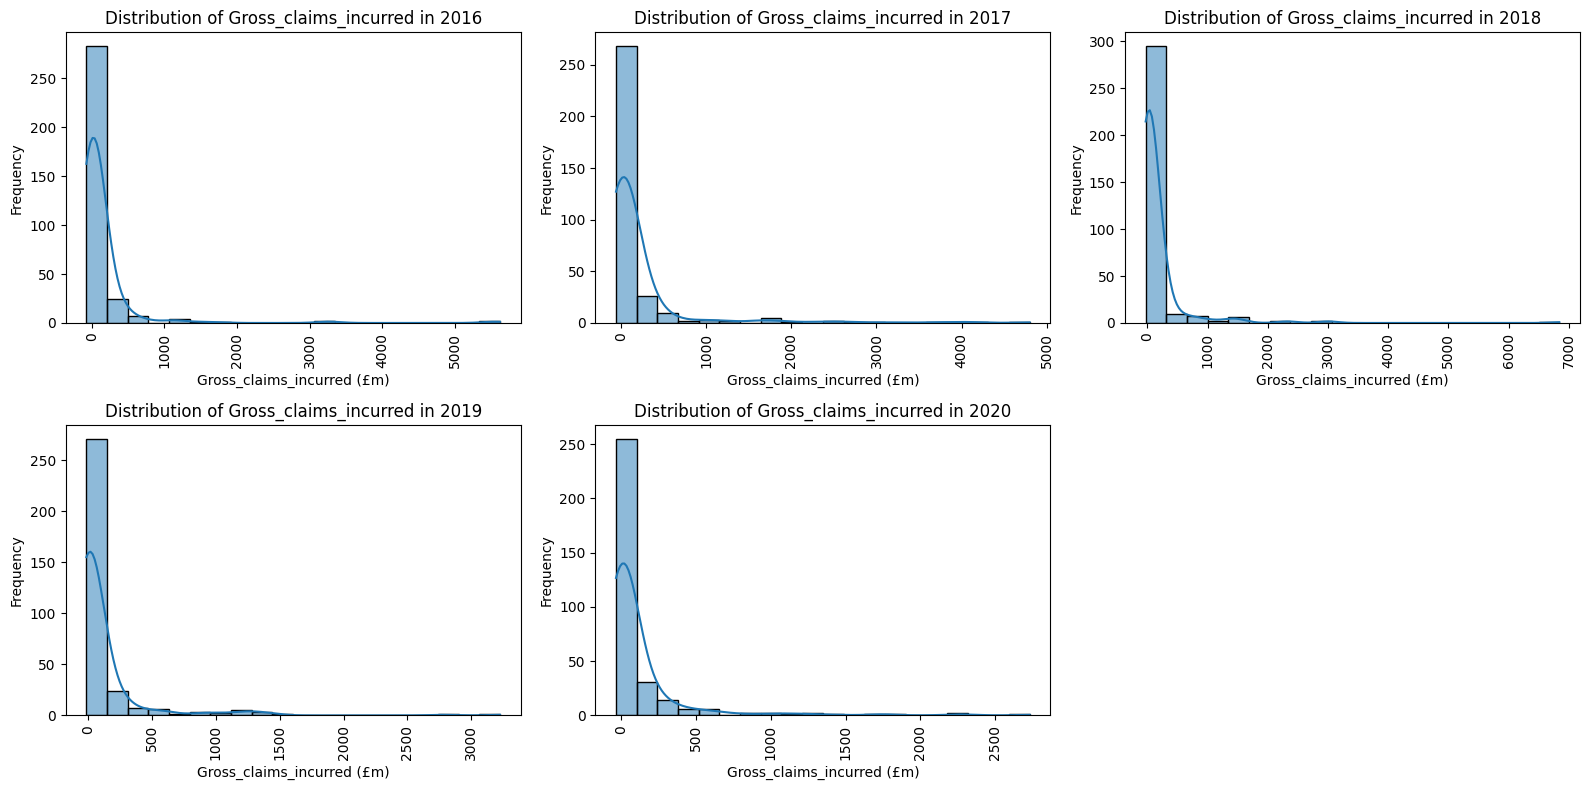

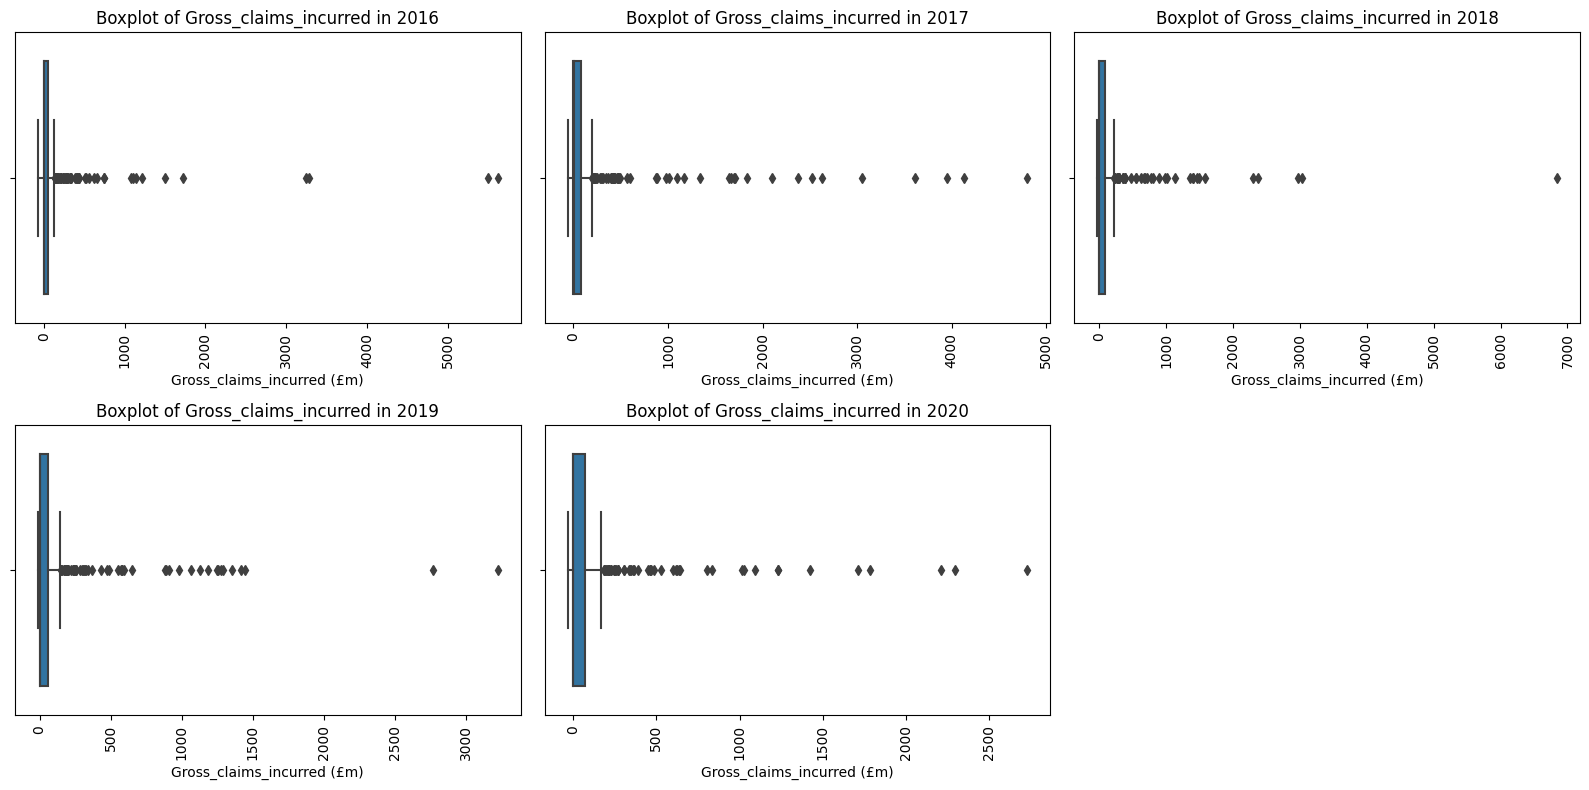

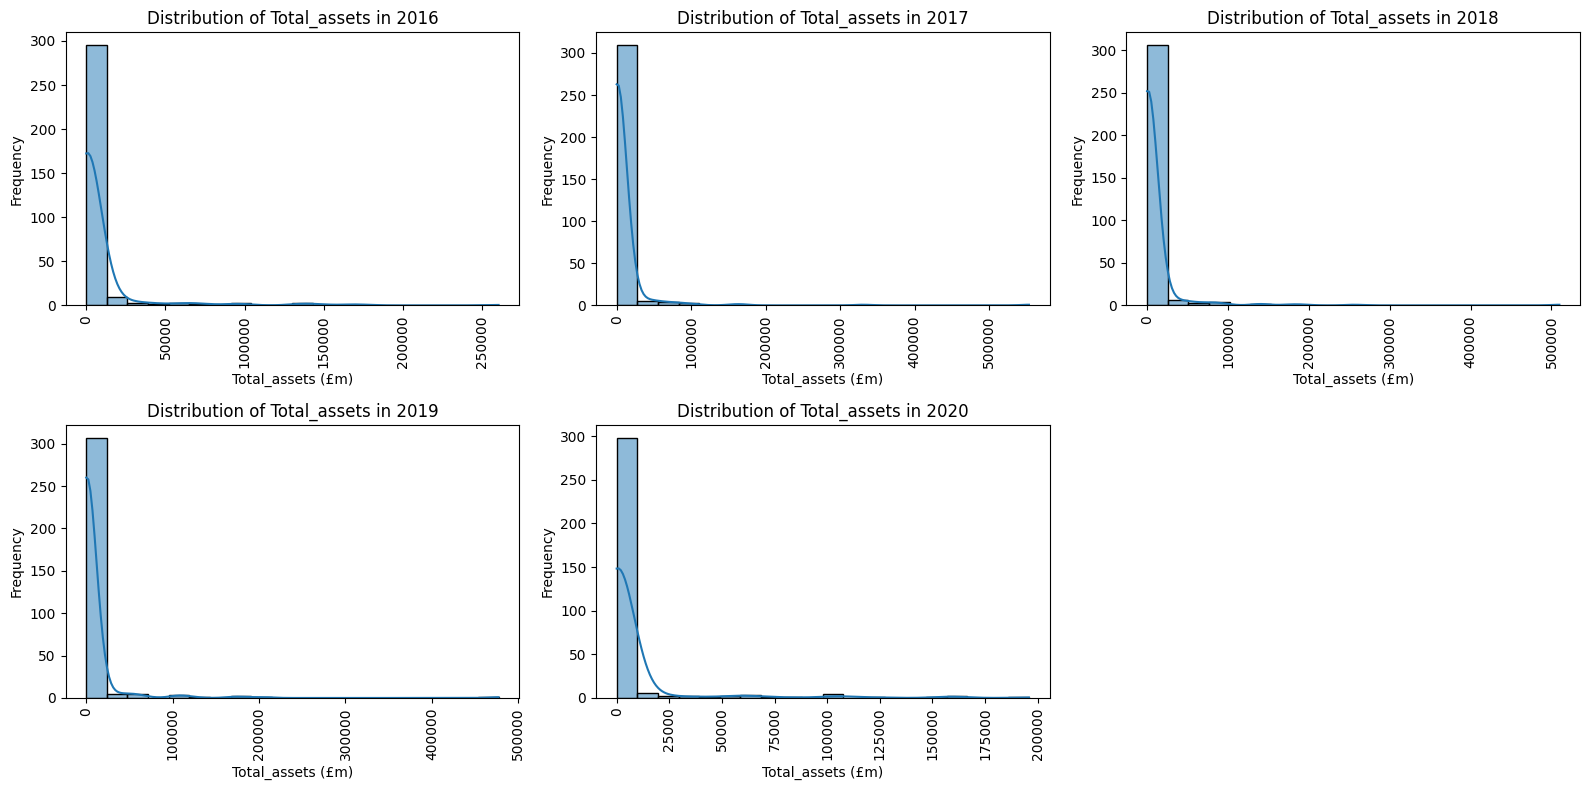

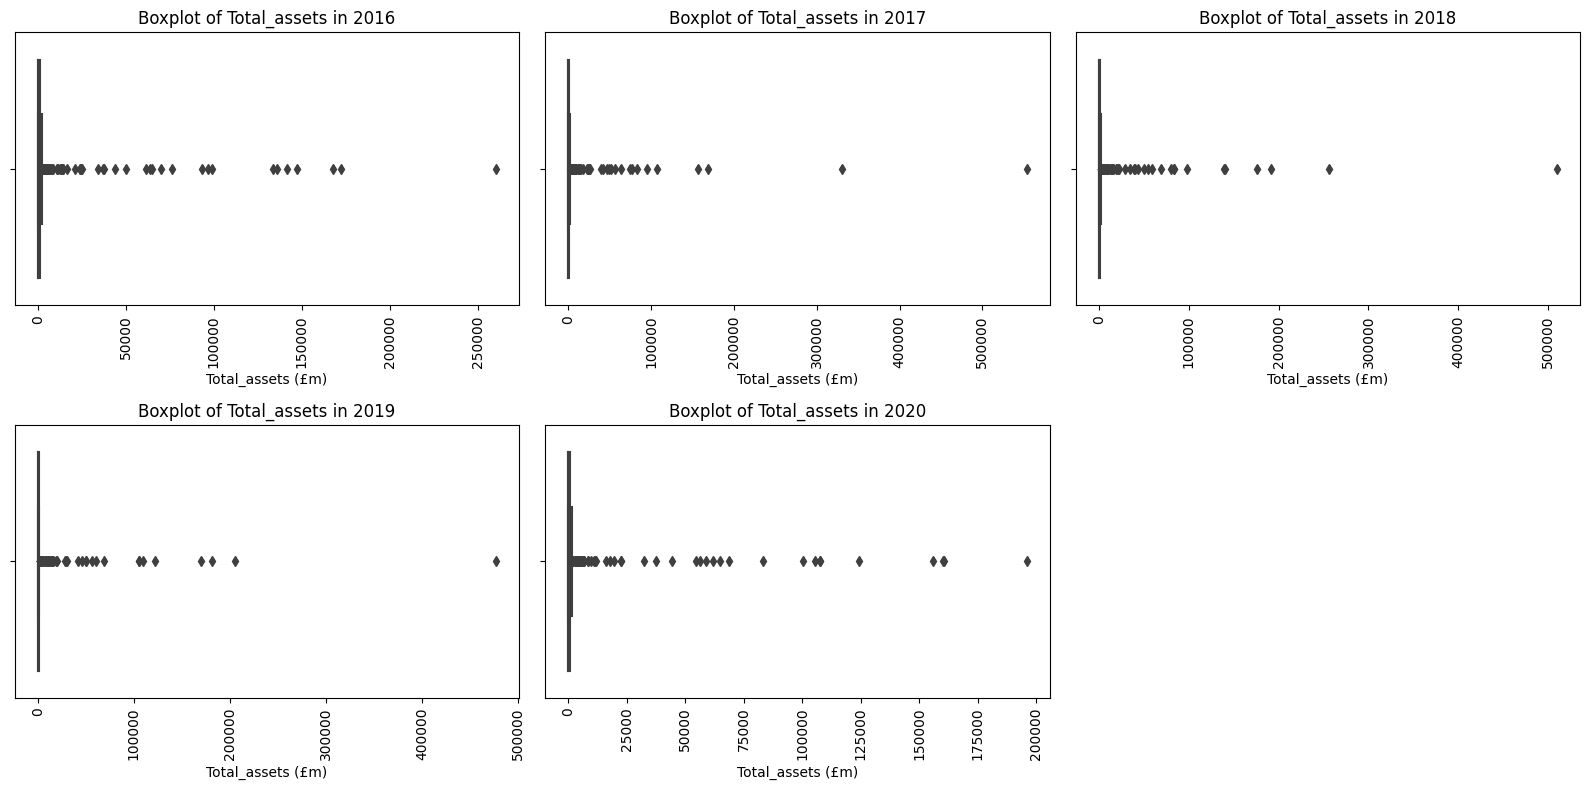

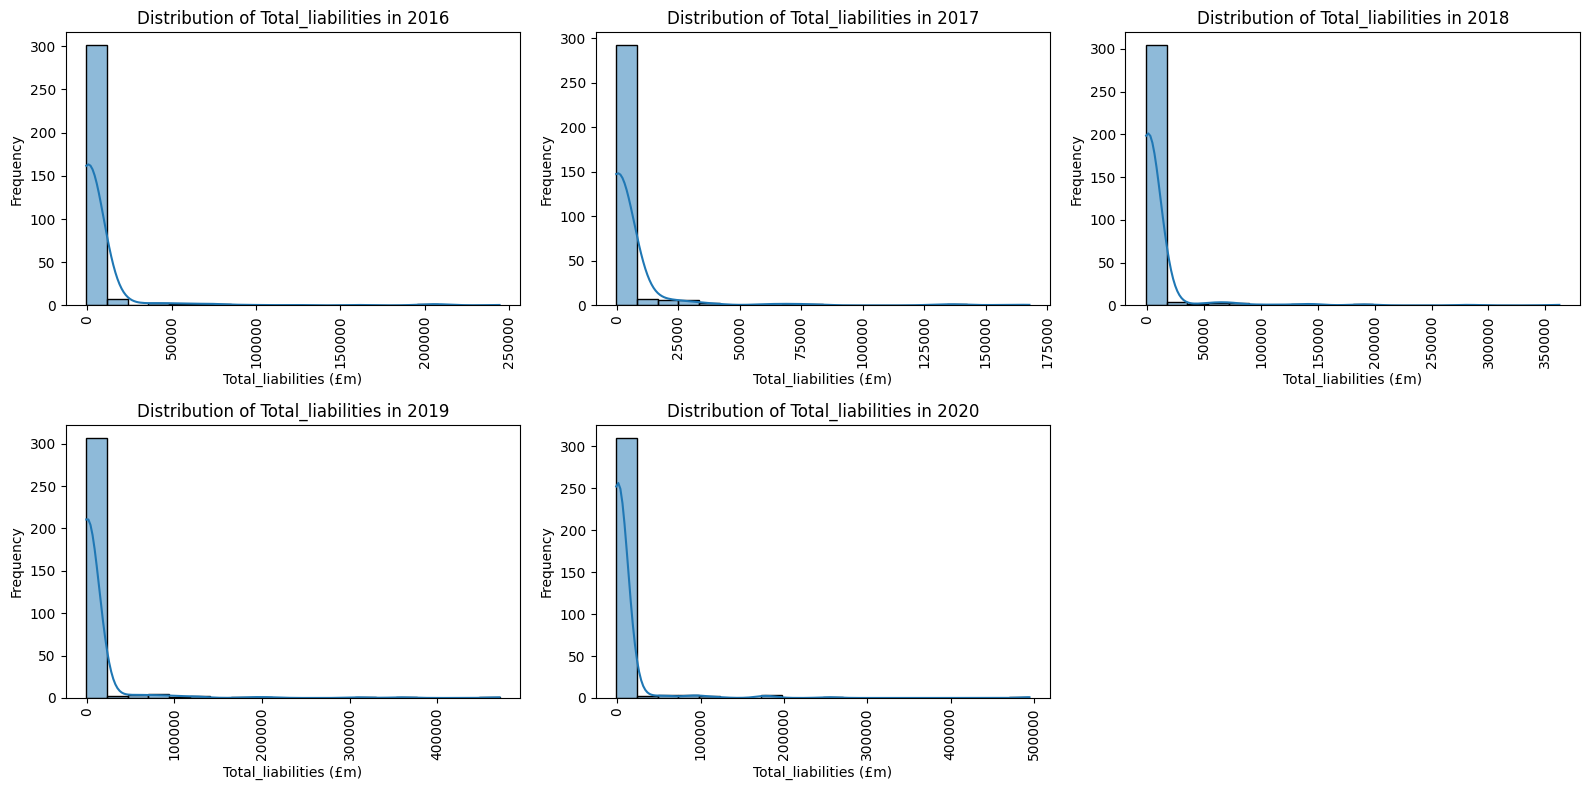

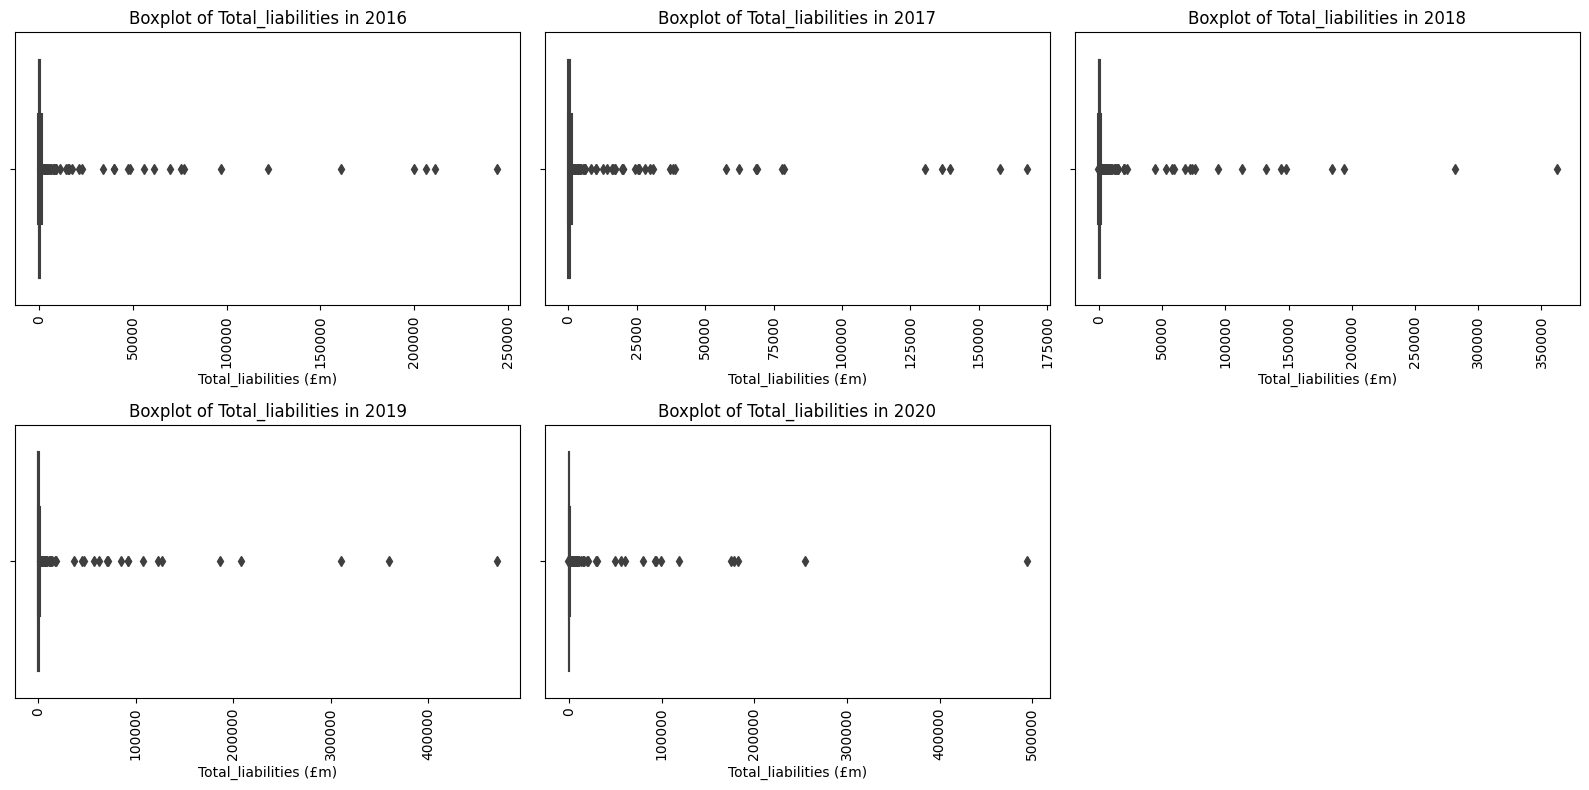

In [13]:
def plot_metric_eda(metric_name):
    """
    Plot histogram and boxplot for a metric over multiple years.

    Parameters:
    - metric_name (str): The name of the metric to be plotted.

    Returns:
    - None: Plots are displayed.
    """
    years = ['2016', '2017', '2018', '2019', '2020']

    # Plot histogram
    plt.figure(figsize=(16, 8))
    for year in years:
        col_name = f'{metric_name} {year}'
        if col_name in merged_df.columns:
            plt.subplot(2, 3, years.index(year) + 1)
            sns.histplot(data=merged_df, x=col_name, bins=20, kde=True)
            plt.title(f'Distribution of {metric_name} in {year}')
            plt.xlabel(f'{metric_name} (£m)')
            plt.ylabel('Frequency')
            plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

    # Plot boxplot
    plt.figure(figsize=(16, 8))
    for year in years:
        col_name = f'{metric_name} {year}'
        if col_name in merged_df.columns:
            plt.subplot(2, 3, years.index(year) + 1)
            sns.boxplot(data=merged_df, x=col_name)
            plt.title(f'Boxplot of {metric_name} in {year}')
            plt.xlabel(f'{metric_name} (£m)')
            plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

# Perform EDA for each metric
metrics_to_plot = ['GWP', 'NWP', 'Gross_claims_incurred', 'Total_assets', 'Total_liabilities']

for metric in metrics_to_plot:
    plot_metric_eda(metric)


### `dual_axis_plot`

This function generates a dual-axis plot for two specified metrics of a given year. The dual-axis plot allows you to visualize the relationship between two metrics for each firm.

#### Parameters
- `metric1` (str): The name of the first metric.
- `metric2` (str): The name of the second metric.
- `year` (str): The year for which the metrics should be plotted.

#### Returns
- None: Displays the dual-axis plot.

---

**Usage Example:**
```python
# Example usage:
dual_axis_plot('Total_liabilities', 'Total_assets', '2018')


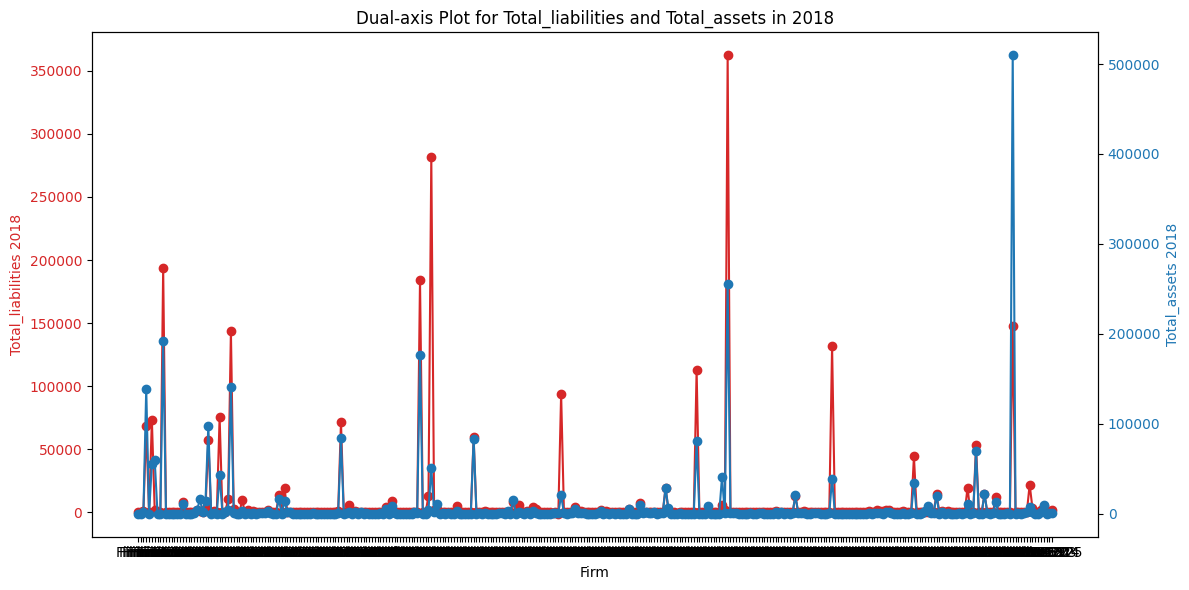

In [14]:
def dual_axis_plot(metric1, metric2, year):
    """
    Plot a dual-axis chart for two metrics of a given year.

    Parameters:
    - metric1 (str): The name of the first metric.
    - metric2 (str): The name of the second metric.
    - year (str): The year for which the metrics should be plotted.

    Returns:
    - None: Displays the dual-axis plot.
    """
    # Check if the columns exist
    if f'{metric1} {year}' in merged_df.columns and f'{metric2} {year}' in merged_df.columns:
        # Create a figure and axis
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot the first metric on the left y-axis
        color = 'tab:red'
        ax1.set_xlabel('Firm')
        ax1.set_ylabel(f'{metric1} {year}', color=color)
        ax1.plot(merged_df['firm_name'], merged_df[f'{metric1} {year}'], color=color, marker='o', label=f'{metric1} {year}')
        ax1.tick_params(axis='y', labelcolor=color)

        # Create a second y-axis for the second metric
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel(f'{metric2} {year}', color=color)
        ax2.plot(merged_df['firm_name'], merged_df[f'{metric2} {year}'], color=color, marker='o', label=f'{metric2} {year}')
        ax2.tick_params(axis='y', labelcolor=color)

        # Display the plot
        plt.title(f'Dual-axis Plot for {metric1} and {metric2} in {year}')
        fig.tight_layout()
        plt.show()
    else:
        print(f"Columns {metric1} {year} or {metric2} {year} do not exist in the dataframe.")

dual_axis_plot('Total_liabilities', 'Total_assets', '2018')


### `detect_outliers`

This function identifies and visualizes potential outliers for a given metric using the Z-score method. Outliers are points that significantly deviate from the mean of the metric.

#### Parameters
- `metric_name` (str): The name of the metric for which outliers should be detected.

#### Returns
- None: Displays a boxplot with outliers and prints potential outlier data.

---

**Usage Example:**
```python
# Example usage:
detect_outliers('Total_liabilities 2020')


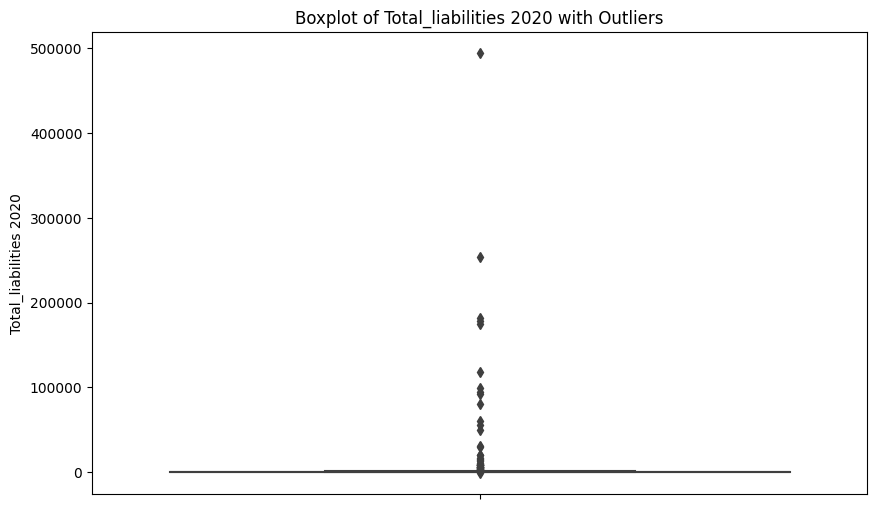

Potential Outliers for Total_liabilities 2020:
     firm_name     NWP  2016     NWP  2017     NWP  2018     NWP  2019  \
6      Firm 7   3148.478356   3307.129485    713.846420  18232.376510   
9     Firm 10    404.116022   3882.087306   6640.433866   5196.618355   
33    Firm 34  10135.258636   3630.292355   3530.844212   -184.091940   
104  Firm 105  41465.110343  18539.933748    -11.983526  21335.956931   
310  Firm 311    -15.161236  14897.664119  12734.766714    381.198271   

        NWP  2020      SCR 2016      SCR 2017     SCR 2018      SCR 2019  ...  \
6     6486.658898   3352.500439   2155.201622  4246.239082   7597.763417  ...   
9      221.986516   3839.041694   5102.458601  2578.827206    323.481575  ...   
33    6105.500028   8785.961467   3011.610527  5924.159038   3884.820732  ...   
104   2612.553473  18258.886129  17563.273844   4194.65909  16716.945095  ...   
310  14566.280927   2394.748642  12441.324415  6189.586851    641.418249  ...   

    Gross_expense_ratio 20

In [15]:
def detect_outliers(metric_name):
    """
    Detect and visualize potential outliers for a given metric using the Z-score.

    Parameters:
    - metric_name (str): The name of the metric for which outliers should be detected.

    Returns:
    - None: Displays a boxplot with outliers and prints potential outlier data.
    """
    # Calculate Z-score
    z_scores = (merged_df[metric_name] - merged_df[metric_name].mean()) / merged_df[metric_name].std()

    # Create boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=merged_df, y=metric_name)
    plt.title(f'Boxplot of {metric_name} with Outliers')
    plt.show()

    # Identify and display outliers based on Z-score
    outliers = merged_df[abs(z_scores) > 3]
    print(f'Potential Outliers for {metric_name}:\n', outliers)

# Example usage for detecting outliers in Total Liabilities in 2020
detect_outliers('Total_liabilities 2020')


### `train_evaluate_random_forest`

This function trains and evaluates a RandomForestRegressor model using specified features and a target variable. It provides insights into the model's performance and feature importance.

#### Parameters
- `features` (list): List of feature column names.
- `target_variable` (str): The target variable column name.
- `df` (pd.DataFrame): The DataFrame containing the data.
- `test_size` (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
- `random_state` (int, optional): Seed for random number generation. Default is 42.

#### Returns
- `dict`: A dictionary containing Mean Squared Error and Feature Importance.

---

**Usage Example:**
```python
# Example usage:
features_to_use = ['NWP  2016', 'NWP  2017', 'NWP  2018', 'NWP  2019', 'GWP 2016', 'GWP 2017', 'GWP 2018', 'GWP 2019']
target_to_predict = 'Net_combined_ratio 2020'

result_dict = train_evaluate_random_forest(features_to_use, target_to_predict, merged_df)
print(result_dict)


In [16]:
def train_evaluate_random_forest(features, target_variable, df, test_size=0.2, random_state=42):
    """
    Train and evaluate a RandomForestRegressor using specified features and target variable.

    Parameters:
    - features (list): List of feature column names.
    - target_variable (str): The target variable column name.
    - df (pd.DataFrame): The DataFrame containing the data.
    - test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
    - random_state (int, optional): Seed for random number generation. Default is 42.

    Returns:
    - dict: Dictionary containing Mean Squared Error and Feature Importance.
    """
    # Handling missing values and outliers
    df_cleaned = df[features + [target_variable]].dropna()

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_cleaned[features], df_cleaned[target_variable], test_size=test_size, random_state=random_state)

    # Standardizing features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initializing the RandomForestRegressor
    regressor = RandomForestRegressor(random_state=random_state)

    # Training the model
    regressor.fit(X_train_scaled, y_train)

    # Making predictions on the test set
    predictions = regressor.predict(X_test_scaled)

    # Evaluating the model
    mse = mean_squared_error(y_test, predictions)

    # Feature importance
    feature_importance = dict(zip(features, regressor.feature_importances_))

    result = {'Mean Squared Error': mse, 'Feature Importance': feature_importance}
    return result

features_to_use = ['NWP  2016', 'NWP  2017', 'NWP  2018', 'NWP  2019', 'GWP 2016', 'GWP 2017', 'GWP 2018', 'GWP 2019']
target_to_predict = 'Net_combined_ratio 2020'

result_dict = train_evaluate_random_forest(features_to_use, target_to_predict, merged_df)
print(result_dict)


{'Mean Squared Error': 595.436676354825, 'Feature Importance': {'NWP  2016': 0.02224075386872898, 'NWP  2017': 0.22270153527988976, 'NWP  2018': 0.3557868864581125, 'NWP  2019': 0.11376629637996119, 'GWP 2016': 0.008382730433637884, 'GWP 2017': 0.2096727823648776, 'GWP 2018': 0.034938283378869235, 'GWP 2019': 0.032510731835922825}}


### `perform_clustering`

This function performs clustering on specified features using KMeans, providing insights into the grouping of data points based on the chosen features.

#### Parameters
- `features` (list): List of feature column names.
- `num_clusters` (int, optional): Number of clusters. Default is 3.
- `df` (pd.DataFrame, optional): The DataFrame containing the data. Default is merged_df.
- `random_state` (int, optional): Seed for random number generation. Default is 42.

#### Returns
- `pd.DataFrame`: DataFrame with an added 'Cluster' column indicating the cluster labels.

---

**Usage Example:**
```python
# Example usage:
cluster_features_to_use = ['NWP  2020', 'GWP 2020']
num_clusters_to_assign = 3

clustered_df = perform_clustering(cluster_features_to_use, num_clusters_to_assign)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


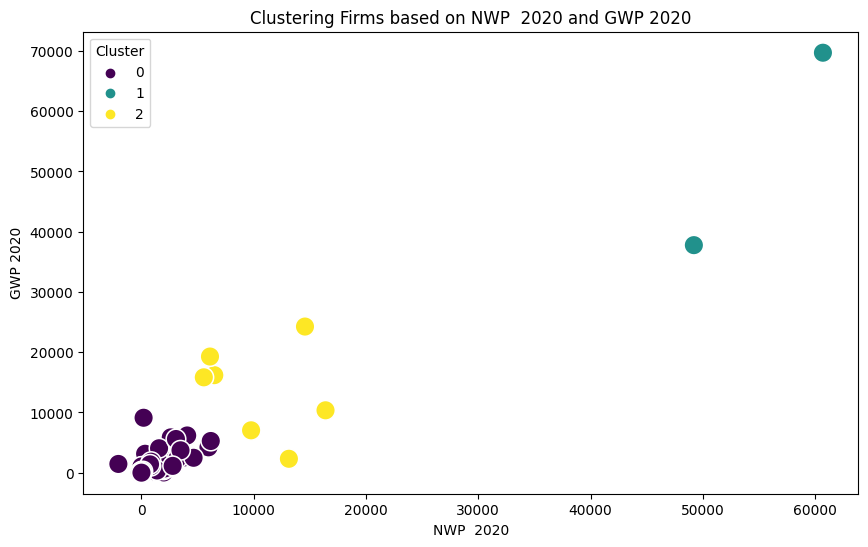

In [17]:
def perform_clustering(features, num_clusters=3, df=merged_df, random_state=42):
    """
    Perform clustering on specified features using KMeans.

    Parameters:
    - features (list): List of feature column names.
    - num_clusters (int, optional): Number of clusters. Default is 3.
    - df (pd.DataFrame, optional): The DataFrame containing the data. Default is merged_df.
    - random_state (int, optional): Seed for random number generation. Default is 42.

    Returns:
    - pd.DataFrame: DataFrame with added 'Cluster' column indicating the cluster labels.
    """
    # Handling missing values and outliers
    cluster_data = df[features].dropna()

    # Standardizing features
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)

    # Initializing KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)

    # Fitting the model
    kmeans.fit(cluster_data_scaled)

    # Adding cluster labels to the original dataframe
    df['Cluster'] = kmeans.labels_

    # Visualizing the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=features[0], y=features[1], hue='Cluster', data=df, palette='viridis', s=200)
    plt.title(f'Clustering Firms based on {features[0]} and {features[1]}')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()

    return df

cluster_features_to_use = ['NWP  2020', 'GWP 2020']
num_clusters_to_assign = 3

clustered_df = perform_clustering(cluster_features_to_use, num_clusters_to_assign)